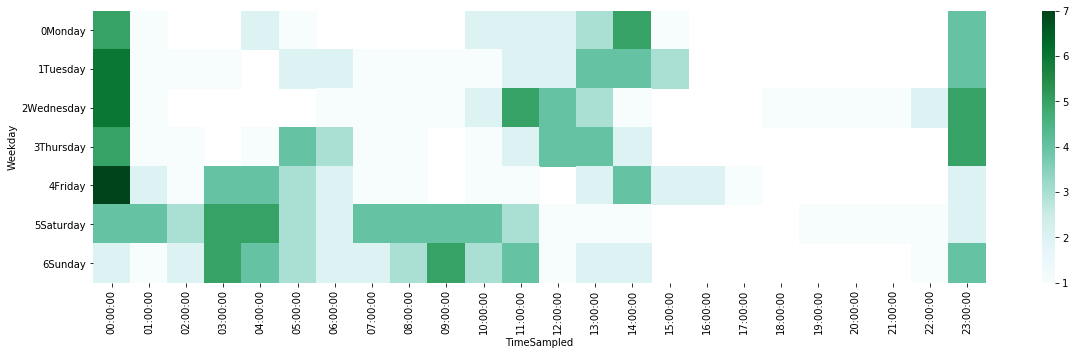

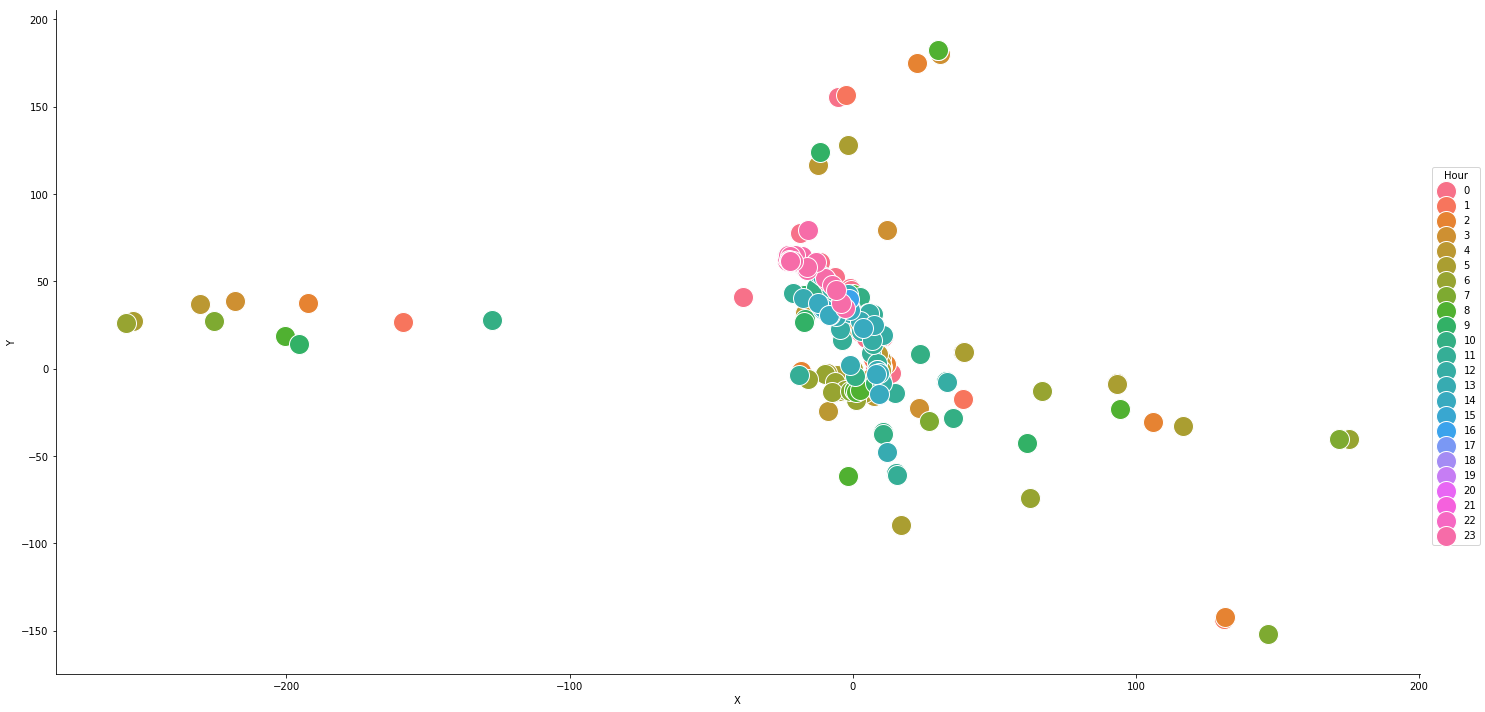

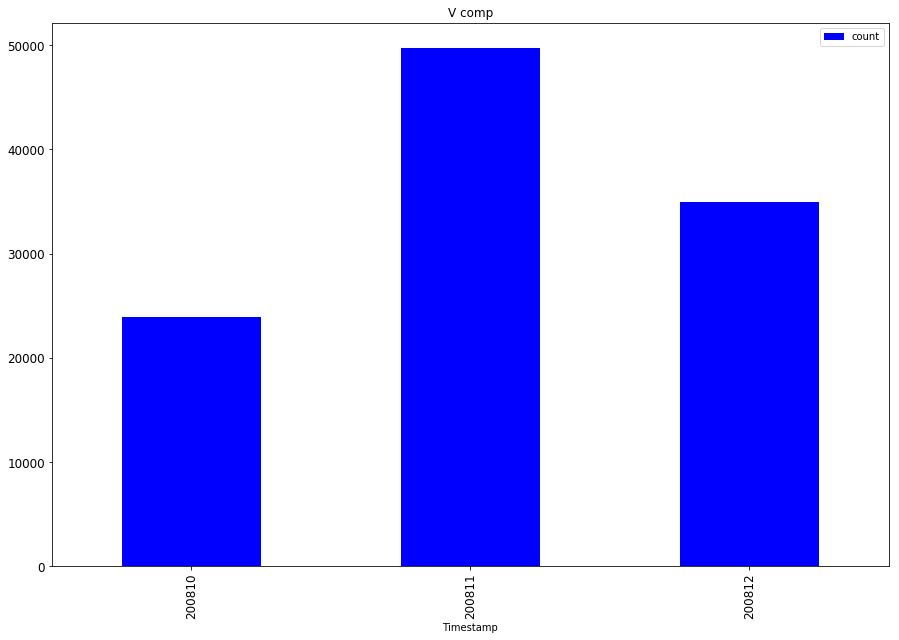

In [2]:
import glob
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import math 
import pylab

#-------------------------------Loading user raw trajectory file ----------------------------------------

#Load file names for user. Change here for different user replace 000 or even path as required
# for i in range(101, 182):
#     user = "%03d"%i
user = "001"
path = "C:/Users/12sha/Documents/Geolife Trajectories 1.3/Data/" + str(user) + "/Trajectory/*.plt"
destination = "C:/Users/12sha/Documents/thesislocation/Data/User 001/"
destfile1 = destination + str(user) + " Weekday vs Hour.png" 
destfile2 = destination + str(user) + " overall xy movements.png"
destfile3 = destination + str(user) + " monthly dest.png"

filenames = glob.glob(path)

#Read the files
list_of_dfs = [pd.read_csv(filename, skiprows=6, header = None) for filename in filenames]

#put the data from list into one dataframe
combined_df = pd.concat(list_of_dfs, ignore_index=True)

#rename columns
combined_df.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']

#add filename as column to identify each row with its source
for filename in filenames:
    combined_df['Filename'] = filename[-18:]

#add timestamp as columns and then make timestamp as index
combined_df["Timestamp"] = combined_df["Date"].map(str) + " " + combined_df["Time"]
combined_df.Timestamp = pd.to_datetime(combined_df.Timestamp)
combined_df.index = pd.to_datetime(combined_df.Timestamp)

#add weekday number as column
combined_df['Weekday'] = combined_df['Timestamp'].dt.weekday.map(str) + combined_df['Timestamp'].dt.weekday_name

#-------------------------------Plot 1 weekday vs each hour count  ----------------------------------------

#plot hourly vs weekly data of the user
#Resample data on hourly basis
sampled_df = combined_df.resample('H').last()

#drop column timestamp to avoid confusion as index is also timestamp
sampled_df = sampled_df.drop(['Timestamp'], axis = 1)

#extract time from timestamp and add it as a column
sampled_df['TimeSampled'] = sampled_df.index.time

#form a pivot table counting number of latitudes for each weekday for each hour
pivot_df = sampled_df.pivot_table(values='Latitude', index='Weekday',columns='TimeSampled',aggfunc=len)

#draw a plot to visualize hourly trend per weekday for the user
fig, ax = plt.subplots(figsize=(20,5))  
sns.heatmap(pivot_df, cmap='BuGn', ax=ax)
plt.savefig(destfile1)
plt.show()

#-------------------------------Plot 2 movement of user in x and y for each hour ------------------------------

#plot to visualize the location trend of the user
#Sample data hourly and take mean, drop nans, reset index
xy_df = combined_df.resample('H').mean()
#xy_df = combined_df
xy_df = xy_df.dropna()
xy_df['Timestamp'] = xy_df.index
xy_df = xy_df.reset_index(drop=True)

#assign the first lat and log as the base for the plot i.e. origin
origin_lat = math.radians(xy_df["Latitude"][0])
origin_lon = math.radians(xy_df["Longitude"][0])

#convert each lat and lon into x and y for the plot w.r.t origin
EARTH_RAD = 6378100
xy_df['X'] = 0.0
xy_df['Y'] = 0.0
for i in range(0, len(xy_df)):
    x = 0
    y = 0
    current_lat = math.radians(xy_df["Latitude"][i])
    current_lon = math.radians(xy_df["Longitude"][i])
    x = ((math.cos(current_lat) + math.cos(origin_lat))/2) * EARTH_RAD * (current_lon - origin_lon) * math.pi / 180
    y = (current_lat - origin_lat)* math.pi/180 * EARTH_RAD
    xy_df.at[i, 'X'] = x
    xy_df.at[i, 'Y'] = y

#plot the x and y's
xy_test_df = xy_df[['X', 'Y', 'Timestamp']].copy()
xy_test_df['Hour'] = xy_test_df.Timestamp.dt.hour
del xy_test_df['Timestamp']
#xy_test_df.head()
fg = sns.FacetGrid(data=xy_test_df, hue='Hour',  size = 10, aspect = 2)
fg.map(plt.scatter, 'X', 'Y', edgecolor="w", s = 400).add_legend()
#xticks = np.arange(-2000,2000,100)
#yticks = np.arange(-2000,2000,100)
#fg.set(xticks=xticks, yticks=yticks)
plt.savefig(destfile2)
plt.show()

#-------------------------------Plot 3 Data count for each user  ----------------------------------------

test = pd.DataFrame()
#test['YearMonth'] = test['Timestamp'].map(lambda x: 100*x.year + x.month)
test['count'] = combined_df.groupby(combined_df.index.year * 100 + combined_df.index.month).size() 
#test.index = pd.to_datetime(test.index)
#test['month'] = test.index.month
test
test.plot(kind='bar', title ="V comp",figsize=(15,10),legend=True, fontsize=12, color = 'b')
plt.savefig(destfile3)
plt.show()
